# Bot-hoven: Music Generation with AI

**A project for PROG74040 Advanced Topics of AI and ML**  
**By Thomas Horvath and Gavin Abeele**

## Project Summary

Bot-hoven is an project that leverages advanced AI and machine learning techniques to generate music. Using Long Short-Term Memory (LSTM) neural networks, the project aims to compose music by learning from existing MIDI datasets. This exploration of AI in the creative domain for a college assignment. The generated compositions are evaluated for their musical coherence and creativity, showcasing the capabilities of AI in generating complex sequences of notes.

### Datasets

The project utilizes MIDI datasets, which are collections of digital musical compositions that can be processed to train the AI model. The MIDI files contain sequences of notes and chords, providing rich data for learning musical patterns.

#### MIDI Datasets

1. **Classical Piano MIDI Music**
   - Provided by Gautam Chutani.
   - Link: [Classical Piano MIDI Music](https://www.kaggle.com/datasets/gautamgc75/classical-piano-MIDI-music)

2. **Classical Music MIDI**
   - Provided by Rakshit, S.
   - Link: [Classical Music MIDI](https://www.kaggle.com/datasets/soumikrakshit/classical-music-MIDI)

### File Structure

- **music/**: Contains the MIDI dataset files used for training.
- **models/**: Contains the trained models and associated weights.
- **outputs/**: Stores the generated MIDI files from the model.
- **loss_curves/**: Contains PNG images of the loss curves over training epochs, providing insight into the model's learning process.

### Disclaimer

This project is computationally intensive and performs best with GPU acceleration. Using a GPU significantly reduces training time and enhances model performance. It is recommended to run the model on a platform that supports GPU processing, such as Google Colab, AWS, or a local machine with an NVIDIA GPU.

## Getting Started

Follow these steps to set up the Bot-hoven project on your local machine.

### Prerequisites

- Ensure you have Python 3.x installed on your system.
- Install Jupyter Notebook or Jupyter Lab to run the notebooks.
- 
### Download the Datasets
You will need to download the MIDI datasets used for training the AI model. Follow these links to download the datasets:

1. **Classical Piano MIDI Music**
   - Provided by Gautam Chutani.
   - Link: [Classical Piano MIDI Music](https://www.kaggle.com/datasets/gautamgc75/classical-piano-MIDI-music)

2. **Classical Music MIDI**
   - Provided by Rakshit, S.
   - Link: [Classical Music MIDI](https://www.kaggle.com/datasets/soumikrakshit/classical-music-MIDI)

#### Organize the Datasets
After downloading the datasets, move the MIDI files into the datasets/music/ directory. Ensure that all MIDI files are placed directly in the music folder without any subdirectories.

#### Steps to Organize Files:
Extract the downloaded dataset archives to your local machine.
Copy all .mid or .midi files into the datasets/music/ folder in the cloned repository.
The final structure should look like this:

### Configure the Variables 
In the third cell block, global and model variables are there to easily configure and modify the system. 

# Environment Setup

## Download Dependencies

In [16]:
%pip install matplotlib pathlib music21 mido pydub fluidsynth midi2audio

Note: you may need to restart the kernel to use updated packages.


## Import the Packages

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from music21 import note, chord, stream, instrument, converter, midi
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
import pickle

## Configure the System Variables

In [18]:
# Global configurations
PLAY_SAMPLE = False       # Option to play a sample of generated music
DATASET = 'music/'      # Root directory for MIDI files
DATASET_SIZE = 5          # Number of MIDI files to use
MODELS_DIR = 'models'    # Directory for saving models
OUTPUT_DIR = 'outputs'   # Directory for saving the MIDI files
LOSS_CURVES_DIR = 'loss_curves'
OUTPUT_NOTES = 500        # Number of notes to generate

# Model parameters
UNITS = 128                               # Units in LSTM layers
DROPOUT_RATE = 0.4                          # Dropout rate for regularization
DENSE_UNITS = 128                         # Units in dense layer
ACTIVATION = 'softmax'                      # Activation function for output layer
LOSS_FUNCTION = 'categorical_crossentropy'  # Loss function
OPTIMIZER = 'adam'                          # Optimizer for training
EPOCHS = 1                                  # Training epochs
BATCH_SIZE = 128                            # Batch size for training

# Data Preprocessing

## Select MIDI Subset Files

This cell selects *n* number of MIDI files for a subdataset at random - each execution will change the subset.

In [19]:
midi_files = []

for dirpath, _, filenames in os.walk(DATASET):
    for file in filenames:
        if file.endswith('.mid') or file.endswith('.midi'):
            midi_files.append(os.path.join(dirpath, file))

selected_midi_files = random.sample(midi_files, min(DATASET_SIZE, len(midi_files)))

for midi_file in selected_midi_files:
    print(midi_file)

music/ty_januar.mid
music/appass_2.mid
music/bor_ps6.mid
music/beethoven_opus90_2.mid
music/alb_se7.mid


## Data Cleaning and Organization

This cell works to collect all the song notes of the file. First parsing the file, collecting song, chords and raw notes. 

In [20]:
# Process selected MIDI files and extract notes and chords for each song
songs_notes = {}

for midi_file in selected_midi_files:
    # Parse the MIDI file to get the complete stream
    midi_stream = converter.parse(midi_file)

    # Display metadata for debugging
    title = midi_stream.metadata.title if midi_stream.metadata else "Unknown"
    composer = midi_stream.metadata.composer if midi_stream.metadata else "Unknown"
    print(f"Title: {title}")
    print(f"Composer: {composer}")

    # Collect raw and processed notes for this song
    song_notes = []
    raw_notes = []

    # Iterate through all parts and set each instrument to Piano
    for part in midi_stream.parts:
        part.insert(0, instrument.Piano())

        # Flatten the stream to access all notes and chords
        notes_to_parse = part.flatten().notes

        # Collect notes and chords
        for element in notes_to_parse:
            raw_notes.append(str(element))
            if isinstance(element, note.Note):
                song_notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                song_notes.append('+'.join(str(n) for n in element.normalOrder))

    # Store notes for this song
    songs_notes[midi_file] = {"raw": raw_notes, "processed": song_notes}
    print(f"Extracted {len(song_notes)} notes from {midi_file}")


c:\Users\Gavin\anaconda3\envs\PROG74040\Lib\site-packages\music21\midi\translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2000 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


Title: None
Composer: None
Extracted 1083 notes from music/ty_januar.mid


c:\Users\Gavin\anaconda3\envs\PROG74040\Lib\site-packages\music21\midi\translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2001 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


Title: None
Composer: None
Extracted 1186 notes from music/appass_2.mid
Title: None
Composer: None
Extracted 518 notes from music/bor_ps6.mid


c:\Users\Gavin\anaconda3\envs\PROG74040\Lib\site-packages\music21\midi\translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2010 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(


Title: None
Composer: None
Extracted 3127 notes from music/beethoven_opus90_2.mid


c:\Users\Gavin\anaconda3\envs\PROG74040\Lib\site-packages\music21\midi\translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2001 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


Title: None
Composer: None
Extracted 1240 notes from music/alb_se7.mid


## Display Metadata

This cell displays the metadata of the file to get an understanding of unique notes and elements. 

In [21]:
# Analyze and display statistics about the notes for each song
for midi_file, notes_data in songs_notes.items():
    print(f"File: {midi_file}")
    print("Total raw elements:", len(notes_data["raw"]))
    print("Raw elements (first 10):", notes_data["raw"][:10])
    print("Total processed notes:", len(notes_data["processed"]))
    print("Unique processed notes:", len(set(notes_data["processed"])))
    print("Processed notes (first 10):", notes_data["processed"][:10])
    print("-" * 40)

File: music/ty_januar.mid
Total raw elements: 1083
Raw elements (first 10): ['<music21.note.Note F#>', '<music21.note.Note G#>', '<music21.note.Note A>', '<music21.note.Note G#>', '<music21.chord.Chord E4 B3>', '<music21.note.Note B>', '<music21.note.Note E>', '<music21.note.Note A>', '<music21.chord.Chord G#4 B4>', '<music21.note.Note E>']
Total processed notes: 1083
Unique processed notes: 106
Processed notes (first 10): ['F#4', 'G#4', 'A4', 'G#4', '11+4', 'B4', 'E4', 'A4', '8+11', 'E4']
----------------------------------------
File: music/appass_2.mid
Total raw elements: 1186
Raw elements (first 10): ['<music21.chord.Chord C#3 F3 G#3>', '<music21.chord.Chord C#3 B-3 F#3>', '<music21.chord.Chord C#3 F3 G#3>', '<music21.chord.Chord B-3 E-3 C#3>', '<music21.chord.Chord C#3 E-3 G#3>', '<music21.chord.Chord G#3 C3 E-3>', '<music21.chord.Chord C#3 F3 G#3>', '<music21.chord.Chord C#4 G#3 F3>', '<music21.chord.Chord F#3 B-3 C#4>', '<music21.chord.Chord G#3 F3 C#4>']
Total processed notes: 1

## Save Notes to File

Notes of the song are saved.

In [22]:
# Serialize and save notes for each song to a file
with open("./songs_notes.pkl", "wb") as file:
    pickle.dump(songs_notes, file)

# Load notes from a file
with open("./songs_notes.pkl", "rb") as file:
    loaded_songs_notes = pickle.load(file)

# Verify loaded notes
for midi_file, notes_data in loaded_songs_notes.items():
    print(f"Loaded {len(notes_data['processed'])} processed notes from {midi_file}")


Loaded 1083 processed notes from music/ty_januar.mid
Loaded 1186 processed notes from music/appass_2.mid
Loaded 518 processed notes from music/bor_ps6.mid
Loaded 3127 processed notes from music/beethoven_opus90_2.mid
Loaded 1240 processed notes from music/alb_se7.mid


## Data Training Preparation

In this cell the data is prepared for training and involved collecting all the musical notes and transforming them into numerical format. 

In [23]:
# Collect all notes from all songs
all_notes = [note for notes_data in songs_notes.values() for note in notes_data["processed"]]

# Get all unique pitch names
pitchnames = sorted(set(all_notes))
n_vocab = len(pitchnames)

# Create a dictionary to map pitches to integers
note_to_int = {element: idx for idx, element in enumerate(pitchnames)}

# Create a reverse mapping
int_to_note = {idx: element for element, idx in note_to_int.items()}

# Sequence length for training
sequence_len = 100

# Prepare input and output sequences
network_input = []
network_output = []

for i in range(len(all_notes) - sequence_len):
    seq_in = all_notes[i: i + sequence_len]
    seq_out = all_notes[i + sequence_len]

    # Map notes to integers
    network_input.append([note_to_int[n] for n in seq_in])
    network_output.append(note_to_int[seq_out])

print(f"Total sequences: {len(network_input)}")

# Convert input data to a numpy array
network_input = np.asarray(network_input)

# Reshape input data into a shape compatible with LSTM layers
normalised_network_input = np.reshape(network_input, (*(network_input.shape), 1))

# Normalize the input data
normalised_network_input = normalised_network_input / float(n_vocab)

# One-hot encode the output data
network_output = to_categorical(network_output, num_classes=n_vocab)

print(f"Input shape: {normalised_network_input.shape}")
print(f"Output shape: {network_output.shape}")


Total sequences: 7054
Input shape: (7054, 100, 1)
Output shape: (7054, 202)


# Model and Training

## Defining Architecture  

This cell constructs the LSTM NN in a sequential manner with three LSTM layers, dropout layers, and sens layers. 

In [24]:
model = Sequential()
model.add(Input(shape=(normalised_network_input.shape[1], normalised_network_input.shape[2])))
model.add(LSTM(units=UNITS, return_sequences=True))
model.add(Dropout(DROPOUT_RATE))
model.add(LSTM(units=UNITS, return_sequences=True))
model.add(Dropout(DROPOUT_RATE))
model.add(LSTM(units=UNITS))
model.add(Dense(DENSE_UNITS))
model.add(Dropout(DROPOUT_RATE))
model.add(Dense(n_vocab, activation=ACTIVATION))
model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER)

# Display model architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 100, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 100, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 202)            │        26,058 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 372,298 (1.42 MB)

 Trainable params: 372,298 (1.42 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

Below is the model training on each epoch. 

In [25]:
# Define model checkpoint to save the best model weights
checkpoint = ModelCheckpoint("weights.keras", monitor='loss', save_best_only=True, mode='min')

# Fit the model
hist = model.fit(normalised_network_input, network_output, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[checkpoint])

56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 245ms/step - loss: 4.9624


## Loss Curve 

A loss curve is calculated to visualize the succssfullness of the model.

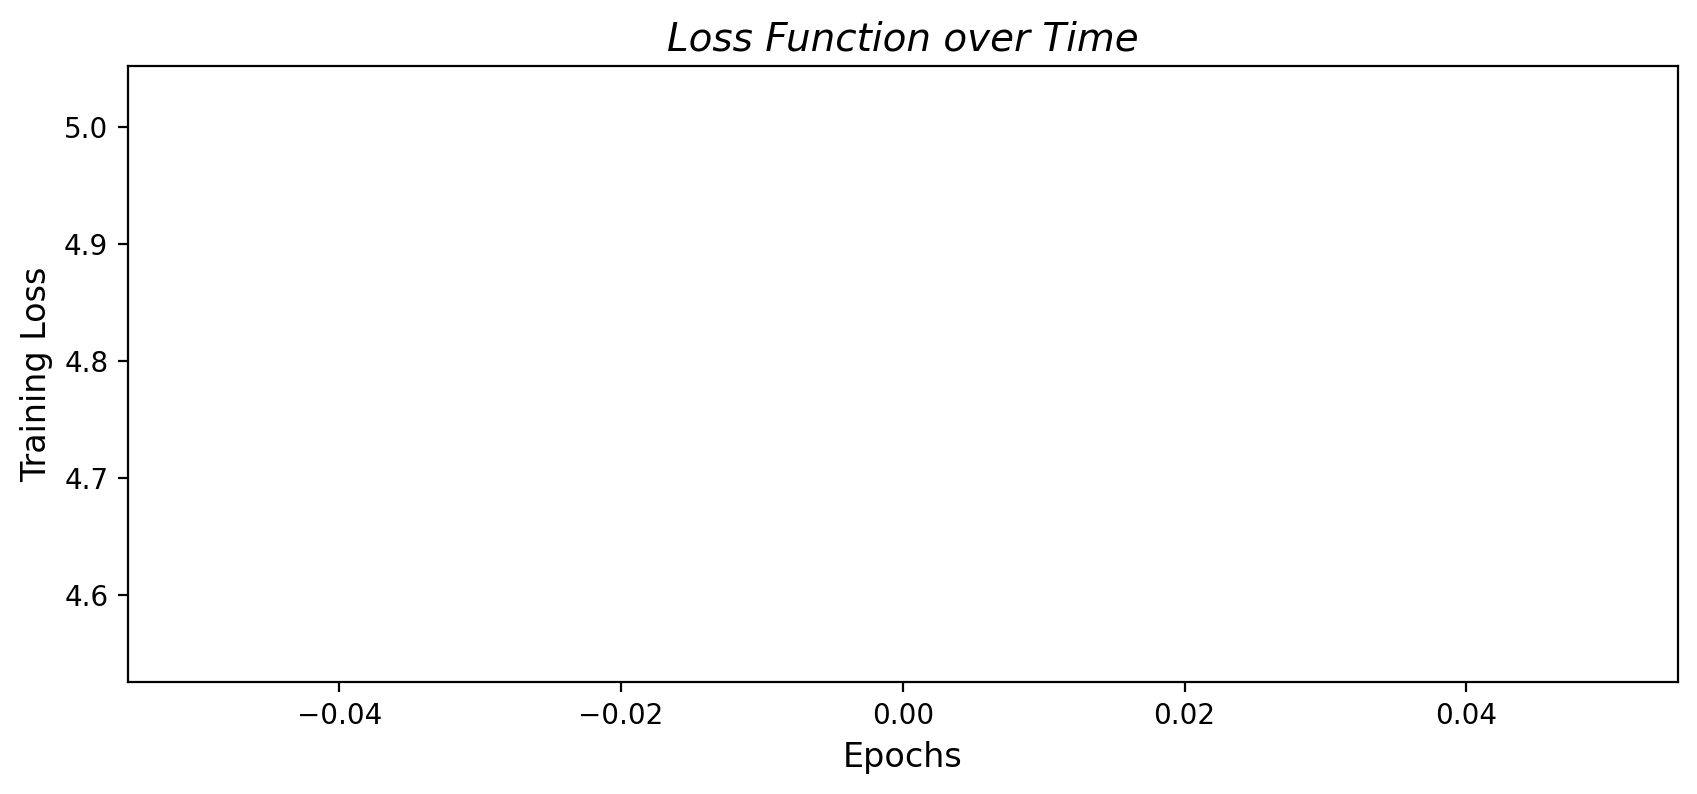

<Figure size 640x480 with 0 Axes>

In [26]:
history_df = pd.DataFrame(hist.history)
fig = plt.figure(figsize=(10, 4))
plt.plot(history_df.index.to_list(), history_df["loss"], linewidth=2)
plt.ylabel("Training Loss", fontsize=12)
plt.xlabel("Epochs", fontsize=12)
plt.title("Loss Function over Time", fontsize=14, fontstyle='italic')
plt.show()

file_path = os.path.join(LOSS_CURVES_DIR, f'learning_curve_units{UNITS}_epochs{EPOCHS}_batch{BATCH_SIZE}.png')
plt.savefig(file_path)

## Saving the Model

In [27]:
# Save the final model
final_model_filename = f"model_units{UNITS}_epochs{EPOCHS}_batch{BATCH_SIZE}.keras"
model.save(os.path.join(MODELS_DIR, final_model_filename))

print(f"Model saved as {final_model_filename}")

Model saved as model_units128_epochs1_batch128.keras


# Prediction and Music Generation

## Predict the Sequence
This section uses the model to generate a sequence of notes by predicting the next note in a sequence iteratively.  

In [28]:
start = np.random.randint(0, len(network_input) - 1)    # Picking a seed

pattern = list(network_input[start])                    # Copy the sequence to a new list

predicted_outputs = []

for note_index in range(OUTPUT_NOTES):

    inp_seq = np.reshape(pattern, (1, len(pattern), 1))     # Reshape pattern to fit model input shape

    inp_seq = inp_seq / float(n_vocab)                      # Normalize the input sequence


    prediction = model.predict(inp_seq, verbose=0)          # Predict the next note
    pred_index = np.argmax(prediction)
    pred_note = int_to_note[pred_index]
    predicted_outputs.append(pred_note)

    
    pattern.append(pred_index)          # Update the pattern: remove the first note and append the predicted note
    pattern = pattern[1:]

print(f"Generated {len(predicted_outputs)} notes.")

Generated 500 notes.


## Converting to MIDI File

In [29]:
offset = 0
output_notes = []

for pattern in predicted_outputs:

    if ('+' in pattern) or pattern.isdigit():       # If the pattern is a chord, split the string into an array of notes
        notes_in_chord = pattern.split('+')

        notes_tmp = []                              # Create Note objects for each note in the chord
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes_tmp.append(new_note)

        new_chord = chord.Chord(notes_tmp)          # Create a Chord from the list of notes
        new_chord.offset = offset
        output_notes.append(new_chord)
    else:
        new_note = note.Note(pattern)           # Create a Note object using the string representation of the pitch
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)

    offset += 0.5

midi_stream = stream.Stream(output_notes)
file_path = os.path.join(OUTPUT_DIR, f'model_units{UNITS}_epochs{EPOCHS}_batch{BATCH_SIZE}.mid')
midi_stream.write(fmt='midi', fp=file_path)

print(f"Generated MIDI file with {len(output_notes)} notes/chords.")

Generated MIDI file with 500 notes/chords.


## Analyzing the Generated MIDI File

The final block analyses the MIDI file to quantify the quality (ie. unique number of cords, starting sequences, etc)

In [30]:
generated_midi_file = os.path.join(OUTPUT_DIR, f'model_units{UNITS}_epochs{EPOCHS}_batch{BATCH_SIZE}.mid')
print(f"\nAnalyzing generated MIDI file: {generated_midi_file}")

midi = converter.parse(generated_midi_file)
notes = []
notes_to_parse = midi.flatten().notes

for element in notes_to_parse:
    if isinstance(element, note.Note):
        notes.append(str(element.pitch))
    elif isinstance(element, chord.Chord):
        notes.append('.'.join(str(n) for n in element.normalOrder))

note_names, counts = np.unique(notes, return_counts=True)
unique_notes = len(note_names)
total_notes = len(notes)
sample_notes = notes[:min(30, len(notes))]

print(f"Total notes: {total_notes}")
print(f"Unique notes: {unique_notes}")
print(f"Sample of notes: {sample_notes}")


Analyzing generated MIDI file: outputs\model_units128_epochs1_batch128.mid
Total notes: 562
Unique notes: 1
Sample of notes: ['B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3']
